# Hist 3368 - Week 9 - Named Entity Recognition

#### by Jo Guldi, expanding on a prompt from https://www.geeksforgeeks.org/python-named-entity-recognition-ner-using-spacy/

#### Setup Spacy

In [ ]:
import pandas as pd, spacy
from datetime import datetime

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'lemmatizer', 'tagger'])

Getting an error? 

* Please note that to use spaCy on M2 you must go to My Interactive Sessions/JupyterLab and add **source /hpc/applications/python_environments/spacy/bin/activate** to the **“Custom environment settings”** field.


#### Load some data

We're going to load the speeches of Congress.

In [3]:
congress = pd.read_csv("/scratch/group/history/hist_3368-jguldi/congress1967-2010.csv")
#congress = pd.read_csv("eighties_data.csv")

In [4]:
congress_1968 = congress[congress['year'] == 1968]
congress_1968[:5]

,Unnamed: 0,Unnamed: 0.1,speech,date,speaker,word_count,year,month,month_year
185175,185175,185175,Mr. President. I suggest the absence of a quorum.,1968-01-15,Mr. MANSFIELD,9,1968,1,1968-01-01
185176,185176,185176,The clerk will call the roll.,1968-01-15,The VICE PRESIDENT,6,1968,1,1968-01-01
185177,185177,185177,I announce that the Senator from New Mexico . ...,1968-01-15,Mr. BYRD of West Virginia,200,1968,1,1968-01-01
185178,185178,185178,I announce that the Senator from Massachusetts...,1968-01-15,Mr. KUCHEL,66,1968,1,1968-01-01
185179,185179,185179,A quorum is present.,1968-01-15,The VICE PRESIDENT,4,1968,1,1968-01-01


In [5]:
congress_1968_sample = congress_1968[:1000]

#### Define some functions

In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from multiprocessing import Pool
import marshal
palette = plt.get_cmap('tab20b') # this tells matplotlib what colors to use.  you can play with this to change the colors.
n = multiprocessing.cpu_count()

In [7]:
def logged_apply(g, func, *args, **kwargs):
    step_percentage = 100. / len(g)
    import sys
    sys.stdout.write('apply progress:   0%')
    sys.stdout.flush()

    def logging_decorator(func):
        def wrapper(*args, **kwargs):
            progress = wrapper.count * step_percentage
            if (progress *100000) % 10000 == 0:  
                sys.stdout.write('\033[D \033[D' * 4 + format(progress, '3.0f') + '%')
            sys.stdout.flush()
            wrapper.count += 1
            return func(*args, **kwargs)
        wrapper.count = 0
        return wrapper

    logged_func = logging_decorator(func)
    res = g.apply(logged_func, *args, **kwargs)
    sys.stdout.write('\033[D \033[D' * 4 + format(100., '3.0f') + '%' + '\n')
    sys.stdout.flush()
    return res

def logged_ner_extractor(text):
    out = logged_apply(text, lambda x: nlp(x)) 
    return out

def parallelize_operation(df, func, n_cores = n-3):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def apply_nlp(df): 
    out = df.apply(nlp)
    return out

#### save each entity as a csv for later use
def all_entities_to_csv(named_entities, dataframe1, name):
    
    for cat in ['LAW', 'LOC', 'PERSON', 'GPE', 'EVENT', 'ORG', 'LANGUAGE']:
        
        print('*****************')
        print('LOOKING FOR ', cat)
        print('**')

        # filter only for the named entities matching label1 and convert Spacy data to a list of strings
        new_column = [[str(ent) for ent in doc.ents if ent.label_ == cat] for doc in named_entities]

        # count overall instances of named entities
        stuffcount = []
        for row in new_column:
            for item in row:
                stuffcount.append(str(item))
        stuffcount[:5]
        top_stuff = pd.Series.value_counts(stuffcount).nlargest(10)
        top_stuff = pd.DataFrame(top_stuff).reset_index()
        top_stuff.columns = ['stuff', 'count']
        top_stuff = top_stuff[top_stuff['count'] > 1]

        print("The top instances of " + cat + " are:")
        print(top_stuff[:5])

        # add named entities back to dataframe
        congress_1968_1 = dataframe1.copy()
        congress_1968_1['stuff'] = new_column

        # explode data
        congress_1968_1 = congress_1968_1.explode('stuff').dropna()


        congress_1968_1.to_csv('/users/jguldi/digital-history/named-entities-per-month-for-' + name + cat + ".csv")     

def ner_mapper_from_csv(label1, name):

    stuff_per_month = pd.read_csv('/users/jguldi/digital-history/named-entities-per-month-for-' + name + '-' + label1 + ".csv") # save a copy of the data

    # cleaning step
    stopwords = ['Chair', 'Speaker', 'Congress', 'House', 'Senate', 'State', 'Chairman', 'ABM', "Abm", "abm", '5year', '10percent', "3mile"]
    stuff_per_month = stuff_per_month[~stuff_per_month['stuff'].isin(stopwords)]
    stuff_per_month = stuff_per_month[~stuff_per_month['stuff'].str.isdigit()] 
    stuff_per_month['stuff'] = stuff_per_month['stuff'].str.replace('the United States', 'U.S.')
    stuff_per_month['stuff'] = stuff_per_month['stuff'].str.title() # make punctuation consistent
    stuff_per_month['stuff'] = stuff_per_month['stuff'].str.replace('[^\w\s]','') # remove punctuation
    stuff_per_month = stuff_per_month[~stuff_per_month['count'] <= 1] # remove very low values 

    # count entities by Month-Year
    stuff_per_month = stuff_per_month.groupby(['month_year', 'stuff'])['stuff'].count()
    stuff_per_month = pd.DataFrame(stuff_per_month) # convert from Series to DataFrame
    stuff_per_month.columns = ['count'] # label the one column "count"
    stuff_per_month = stuff_per_month.reset_index() # turn the multi-index into columns 'year' and 'vocab'
    
    # find max per month
    top_stuff_per_month = stuff_per_month.groupby(['month_year']).apply(lambda x: x.sort_values('count', ascending = False)).reset_index(drop=True)
    top_stuff_per_month = top_stuff_per_month.groupby('month_year').head(3)
    top_stuff_per_month[:20]      

    top_over_time = stuff_per_month[stuff_per_month['stuff'].isin(top_stuff_per_month['stuff'].tolist() + top_stuff['stuff'].tolist())] # get the occurrences per month of the stuff talked about in multiple monhts
    
    # format time
    top_over_time.loc[:,'month_year'] = pd.to_datetime(top_over_time['month_year'])

    # Graph entities 
    plt.clf() # clear last output
    plt.figure(figsize=(8, 6), dpi=300)
    
    plt.style.use('seaborn-darkgrid') # this gives us a grid with a dark background.  you can play with this to change the style.
    num=0

    for entity in set(top_over_time['stuff']): # one loop for each color/line
        
        # get points
        num+=1 # for each new word, the counter 'num' changes 
        x = top_over_time.loc[top_over_time['stuff'] == entity, 'month_year'] # x points
        y = top_over_time.loc[top_over_time['stuff'] == entity, 'count'] # y points
        x2, y2 = zip(*sorted(zip(x, y))) # get everything in the right order
        
        # make a line
        plt.plot(x2, # x axis 
             y2,  # y axis
             '-o', # make dots with lines
             color=palette(num), alpha=0.7, label=entity) # num tells the plot to choose a different color this time
        
        # make labels
        y3 = max(y2) # label lines at their highest point
        entity_points = top_over_time[top_over_time['stuff'] == entity]
        x3 = random.choice(entity_points[entity_points['count'] == max(entity_points['count'])]['month_year'].tolist()) # more for finding the highest point
        plt.text(x3, y3, entity, color = palette(num), size = 10) # this is the code to supply a label for each line

    legd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # move the legend
    
    plt.xticks(rotation=90)
    plt.title("Figure: Top " + label1 + "s Mentioned in Congress, 1967-2010", loc='left', fontsize=25, fontweight=5, color='Blue')
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.subplots_adjust(right=0.9) # add padding to the right so it doesn't get cut off
    plt.savefig('/users/jguldi/digital-history/ner-for-' + name + '-' + label1 + '-.jpg', bbox_inches='tight') # save - with extra commands so it doesn't get cut off 
    plt.figure()


### Sample

In [10]:
import time

#### Lambda x with a Progress Bar

In [11]:
start = time.time()

In [12]:
named_entities = logged_apply(congress_1968_sample['speech'], lambda x: nlp(x))

apply progress:   0%      0%      0%      0%      0%      0%      1%      1%      1%      1%      1%      1%      2%      2%      2%      2%      2%      2%      2%      3%      3%      3%      3%      3%      3%      3%      4%      4%      4%      4%      4%      4%      4%      4%      5%      5%      5%      5%      6%      6%      6%      6%      6%      6%      6%      6%      6%      7%      7%      7%      7%      7%      7%      7%      8%      8%      8%      8%      8%      8%      8%      8%      9%      9%      9%      9%      9%     10%     10%     10%     10%     10%     11%     11%     11%     11%     11%     11%     11%     12%     12%     12%     12%     12%     12%     12%     12%     12%     13%     13%     13%     13%     13%     13%     13%     14%     14%     14%     14%     14%     14%     14%     14%     14%     15%     15%     15%     15%     15%     15%     15%     16%     16%     16%     16%     16%     16%     16%     16%     17%     17%     17%     17%    

In [13]:
finish = time.time()
print(finish-start)

26.207531452178955


#### Apply_NLP w Multiple Cores

In [14]:
start = time.time()

In [15]:
named_entities = parallelize_operation(congress_1968_sample['speech'], apply_nlp)

In [16]:
finish = time.time()
print(finish-start)

20.519509315490723


#### Logged NER Extractor w Multiple Cores

In [17]:
start = time.time()

In [ ]:
named_entities = parallelize_operation(congress_1968_sample['speech'], logged_ner_extractor) # over multiple cores

apply progress:   0%      0%apply progress:   0%apply progress:   0%apply progress:   0%apply progress:   0%apply progress:   0%apply progress:   0%apply progress:   0%apply progress:   0%apply progress:   0%apply progress:   0%apply progress:   0%apply progress:   0%apply progress:   0%apply progress:   0%apply progress:   0%apply progress:   0%      0%apply progress:   0%apply progress:   0%      0%apply progress:   0%apply progress:   0%apply progress:   0%apply progress:   0%apply progress:   0%      0%apply progress:   0%      0%      0%apply progress:   0%apply progress:   0%      0%      0%      0%      0%      0%      0%      0%      0%      0%      0%      0%      0%      0%      0%      0%      0%      0%      0%      0%apply progress:   0%apply progress:   0%apply progress:   0%      0%      0%apply progress:   0%apply progress:   0%apply progress:   0%apply progress:   0%      0%      0%      0%      0%apply progress:   0%apply progress:   0%      0%apply progress:   0%appl

In [ ]:
finish = time.time()
print(finish-start)

### Congress 1968

#### Processing Over All of 1968 with a Progress Bar

In [12]:
import time

In [13]:
start = time.time()

In [14]:
named_entities1 = logged_apply(congress_1968['speech'], lambda x: nlp(x))

apply progress:   0%      0%     12%     25%

KeyboardInterrupt: 

In [ ]:
finish = time.time()
print(finish-start)

#### Processing in Parallel With Multiple Cores

In [15]:
start = time.time()

In [16]:
named_entities1 = parallelize_operation(congress_1968['speech'], apply_nlp)

In [17]:
finish = time.time()
print(finish-start)

618.9664306640625


#### Save Entities from 1968 

In [ ]:
start = time.time()

In [ ]:
all_entities_to_csv(named_entities1, congress_1968, 'congress-1968')

In [ ]:
finish = time.time()
print(finish-start)

#### Graph Entities from 1968 Over Time

*****************
LOOKING FOR  LOC
**
The top instances of LOC are:
             stuff  count
0           Europe   1344
1         Americas   1087
2   Southeast Asia    919
3    North Vietnam    838
4  the Middle East    771


/hpc/applications/python_environments/spacy/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


*****************
LOOKING FOR  PERSON
**
The top instances of PERSON are:
                stuff  count
0             Speaker  39543
1            Chairman  15901
2             Johnson   3561
3             Kennedy   1186
4  Martin Luther King    804


/hpc/applications/python_environments/spacy/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


*****************
LOOKING FOR  GPE
**
The top instances of GPE are:
               stuff  count
0  the United States  16794
1            Vietnam   7773
2               U.S.   6880
3         Washington   6835
4           New York   6317


/hpc/applications/python_environments/spacy/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


*****************
LOOKING FOR  EVENT
**
The top instances of EVENT are:
             stuff  count
0     World War II   1206
1    South Vietnam    854
2  the Vietnam war    443
3    North Vietnam    296
4     World War I.    153


/hpc/applications/python_environments/spacy/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


*****************
LOOKING FOR  ORG
**
The top instances of ORG are:
                    stuff  count
0                Congress  27712
1                  Senate  23148
2                   House  21538
3                   State  15333
4  the Federal Government   4258


/hpc/applications/python_environments/spacy/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<Figure size 432x288 with 0 Axes>

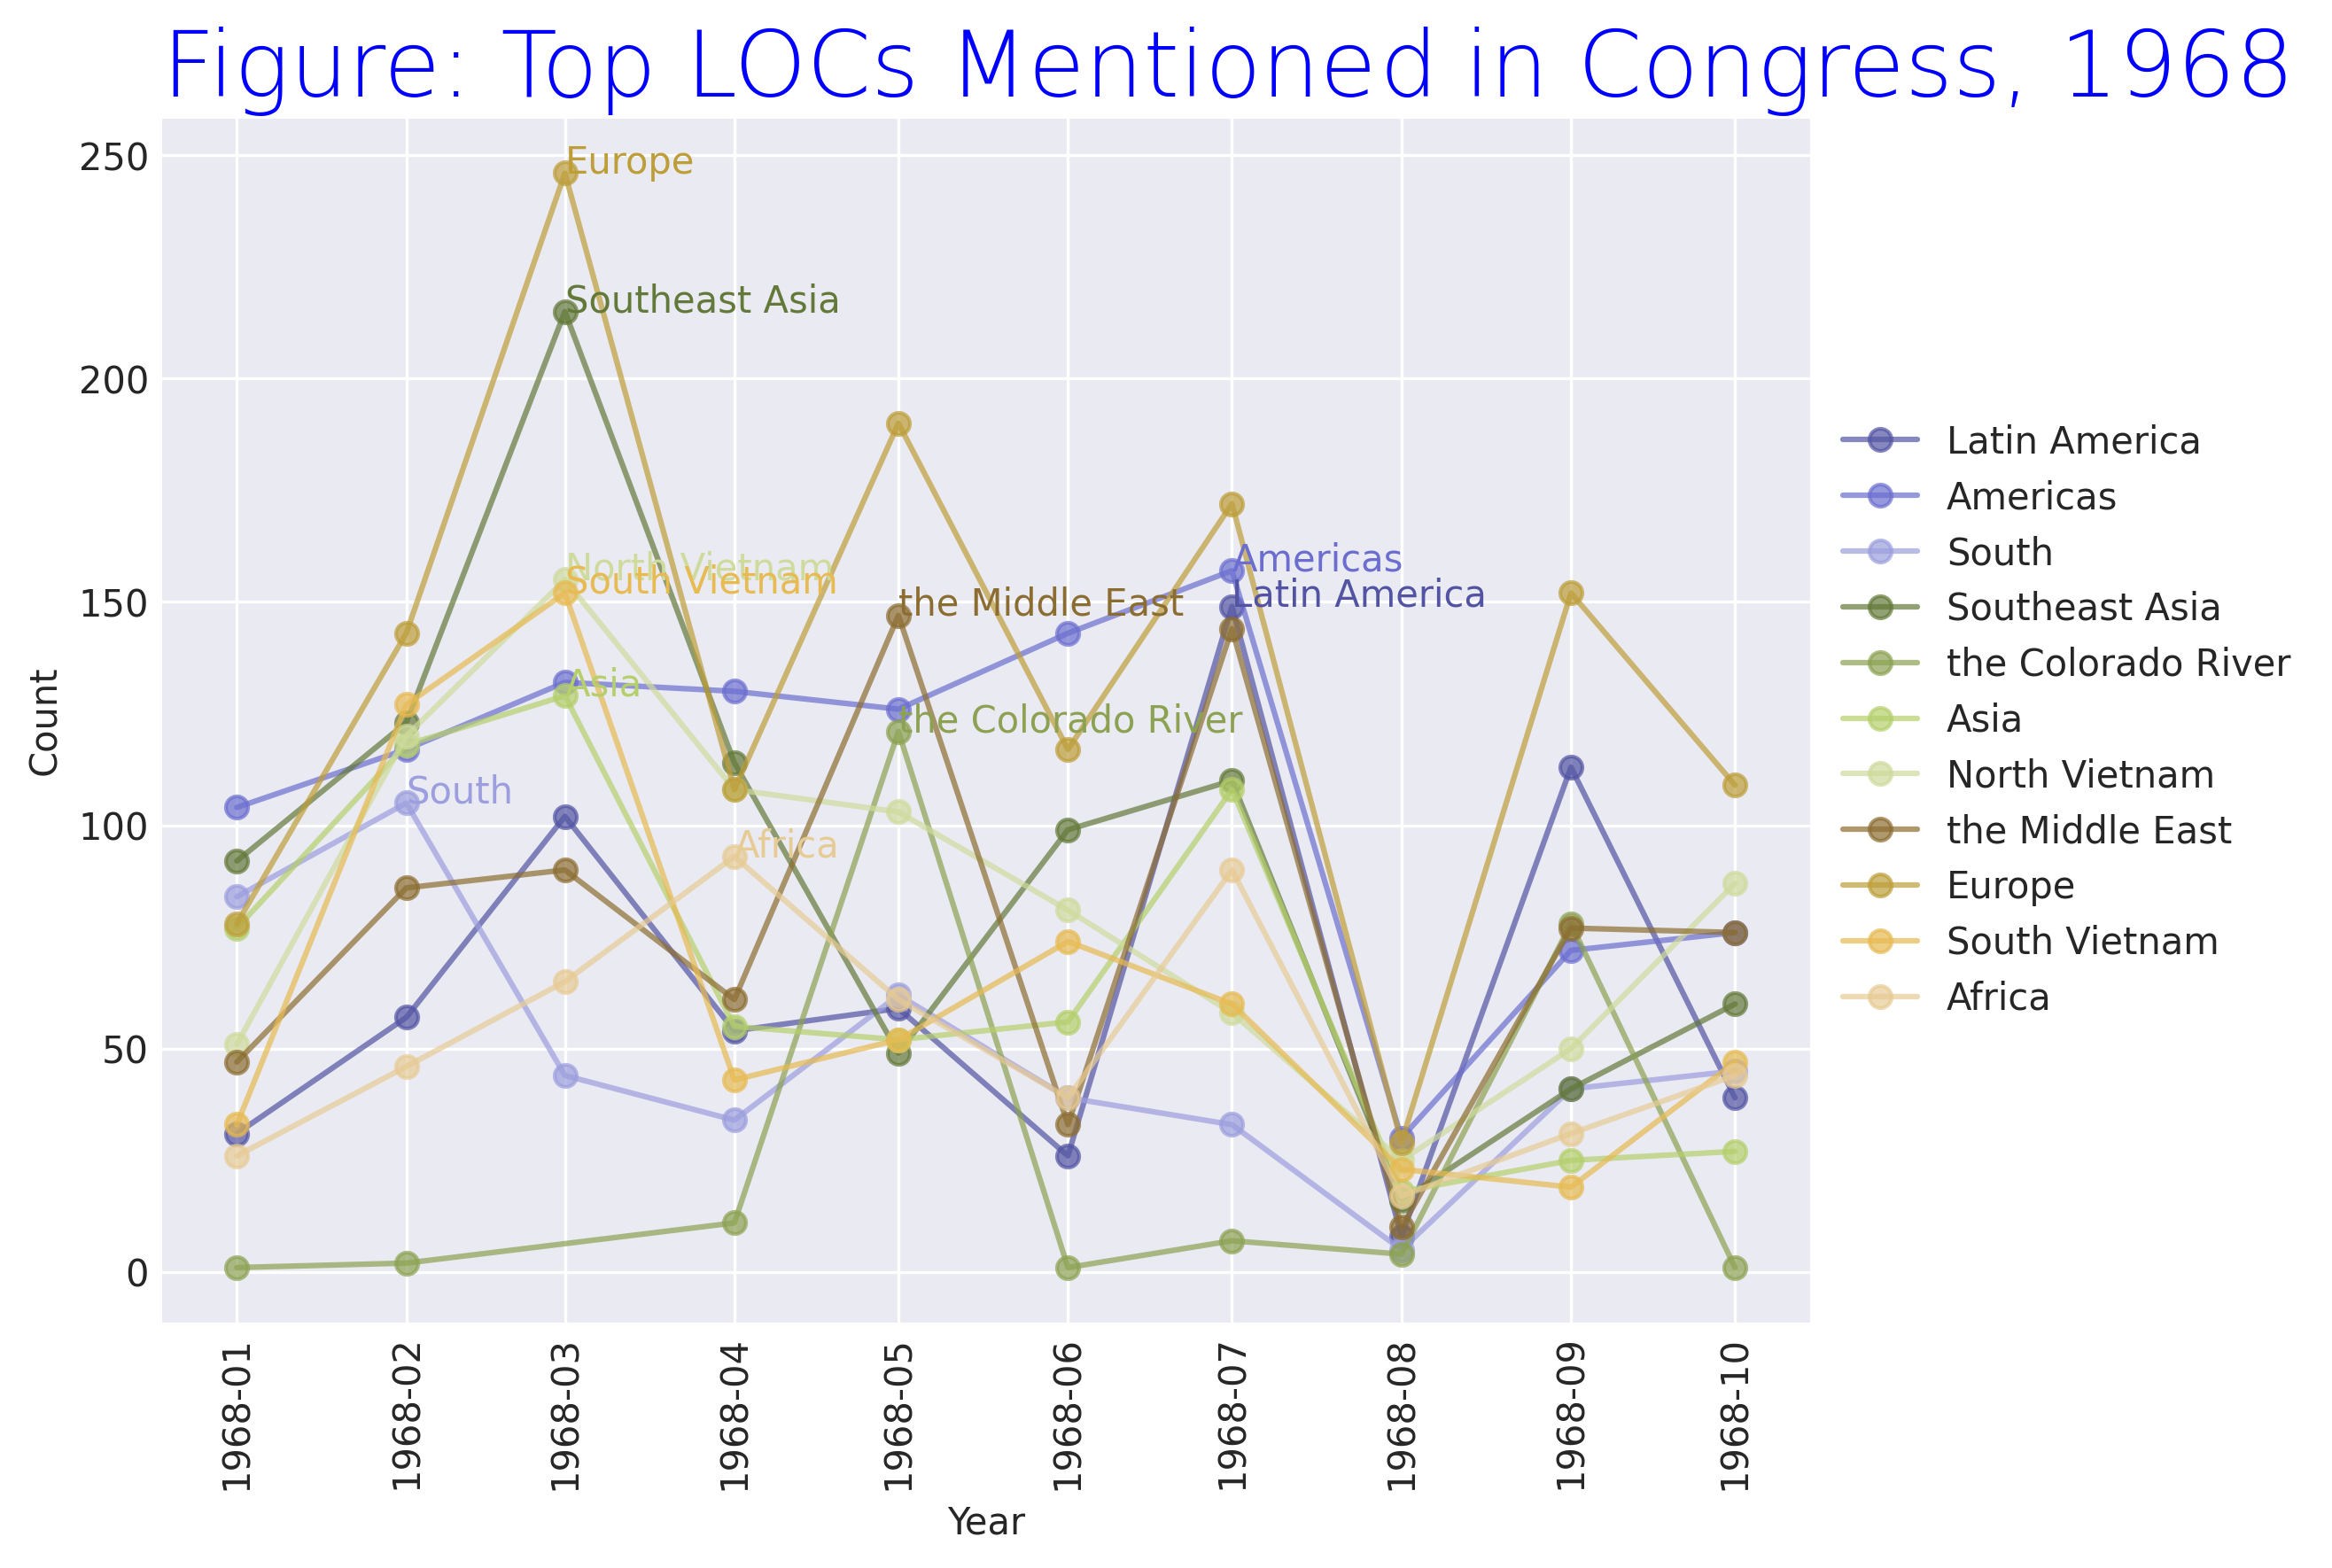

<Figure size 432x288 with 0 Axes>

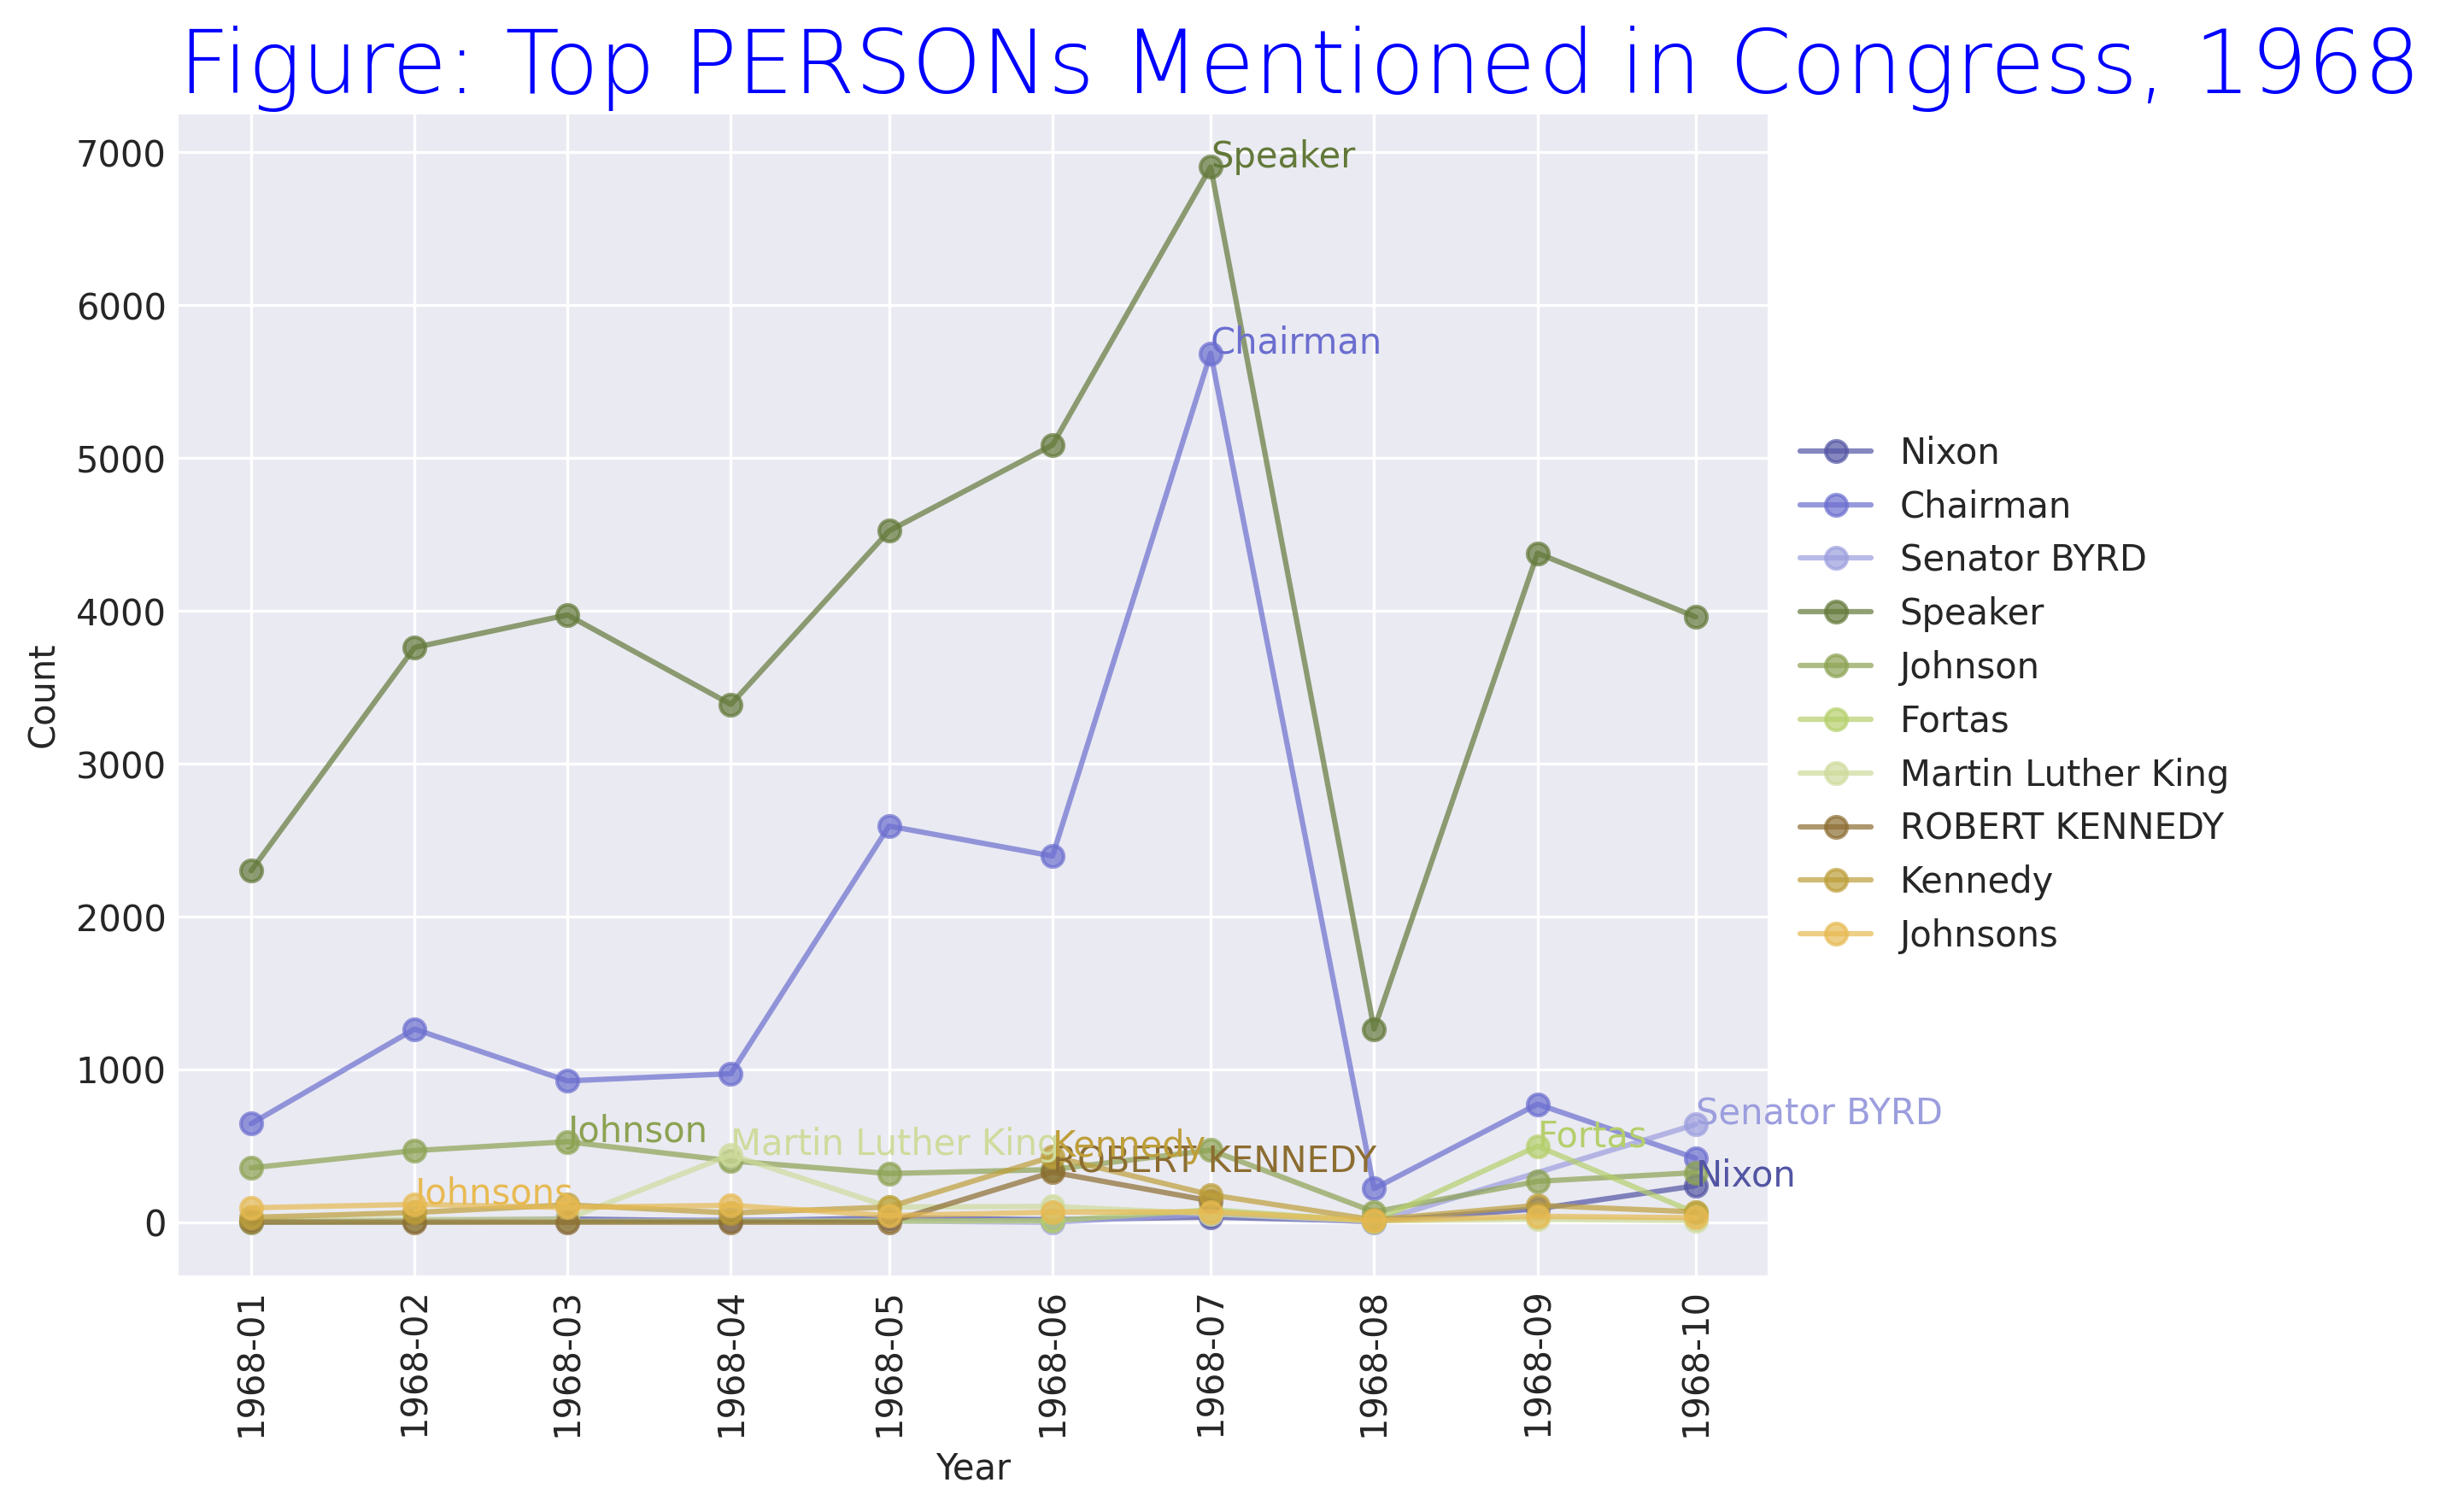

<Figure size 432x288 with 0 Axes>

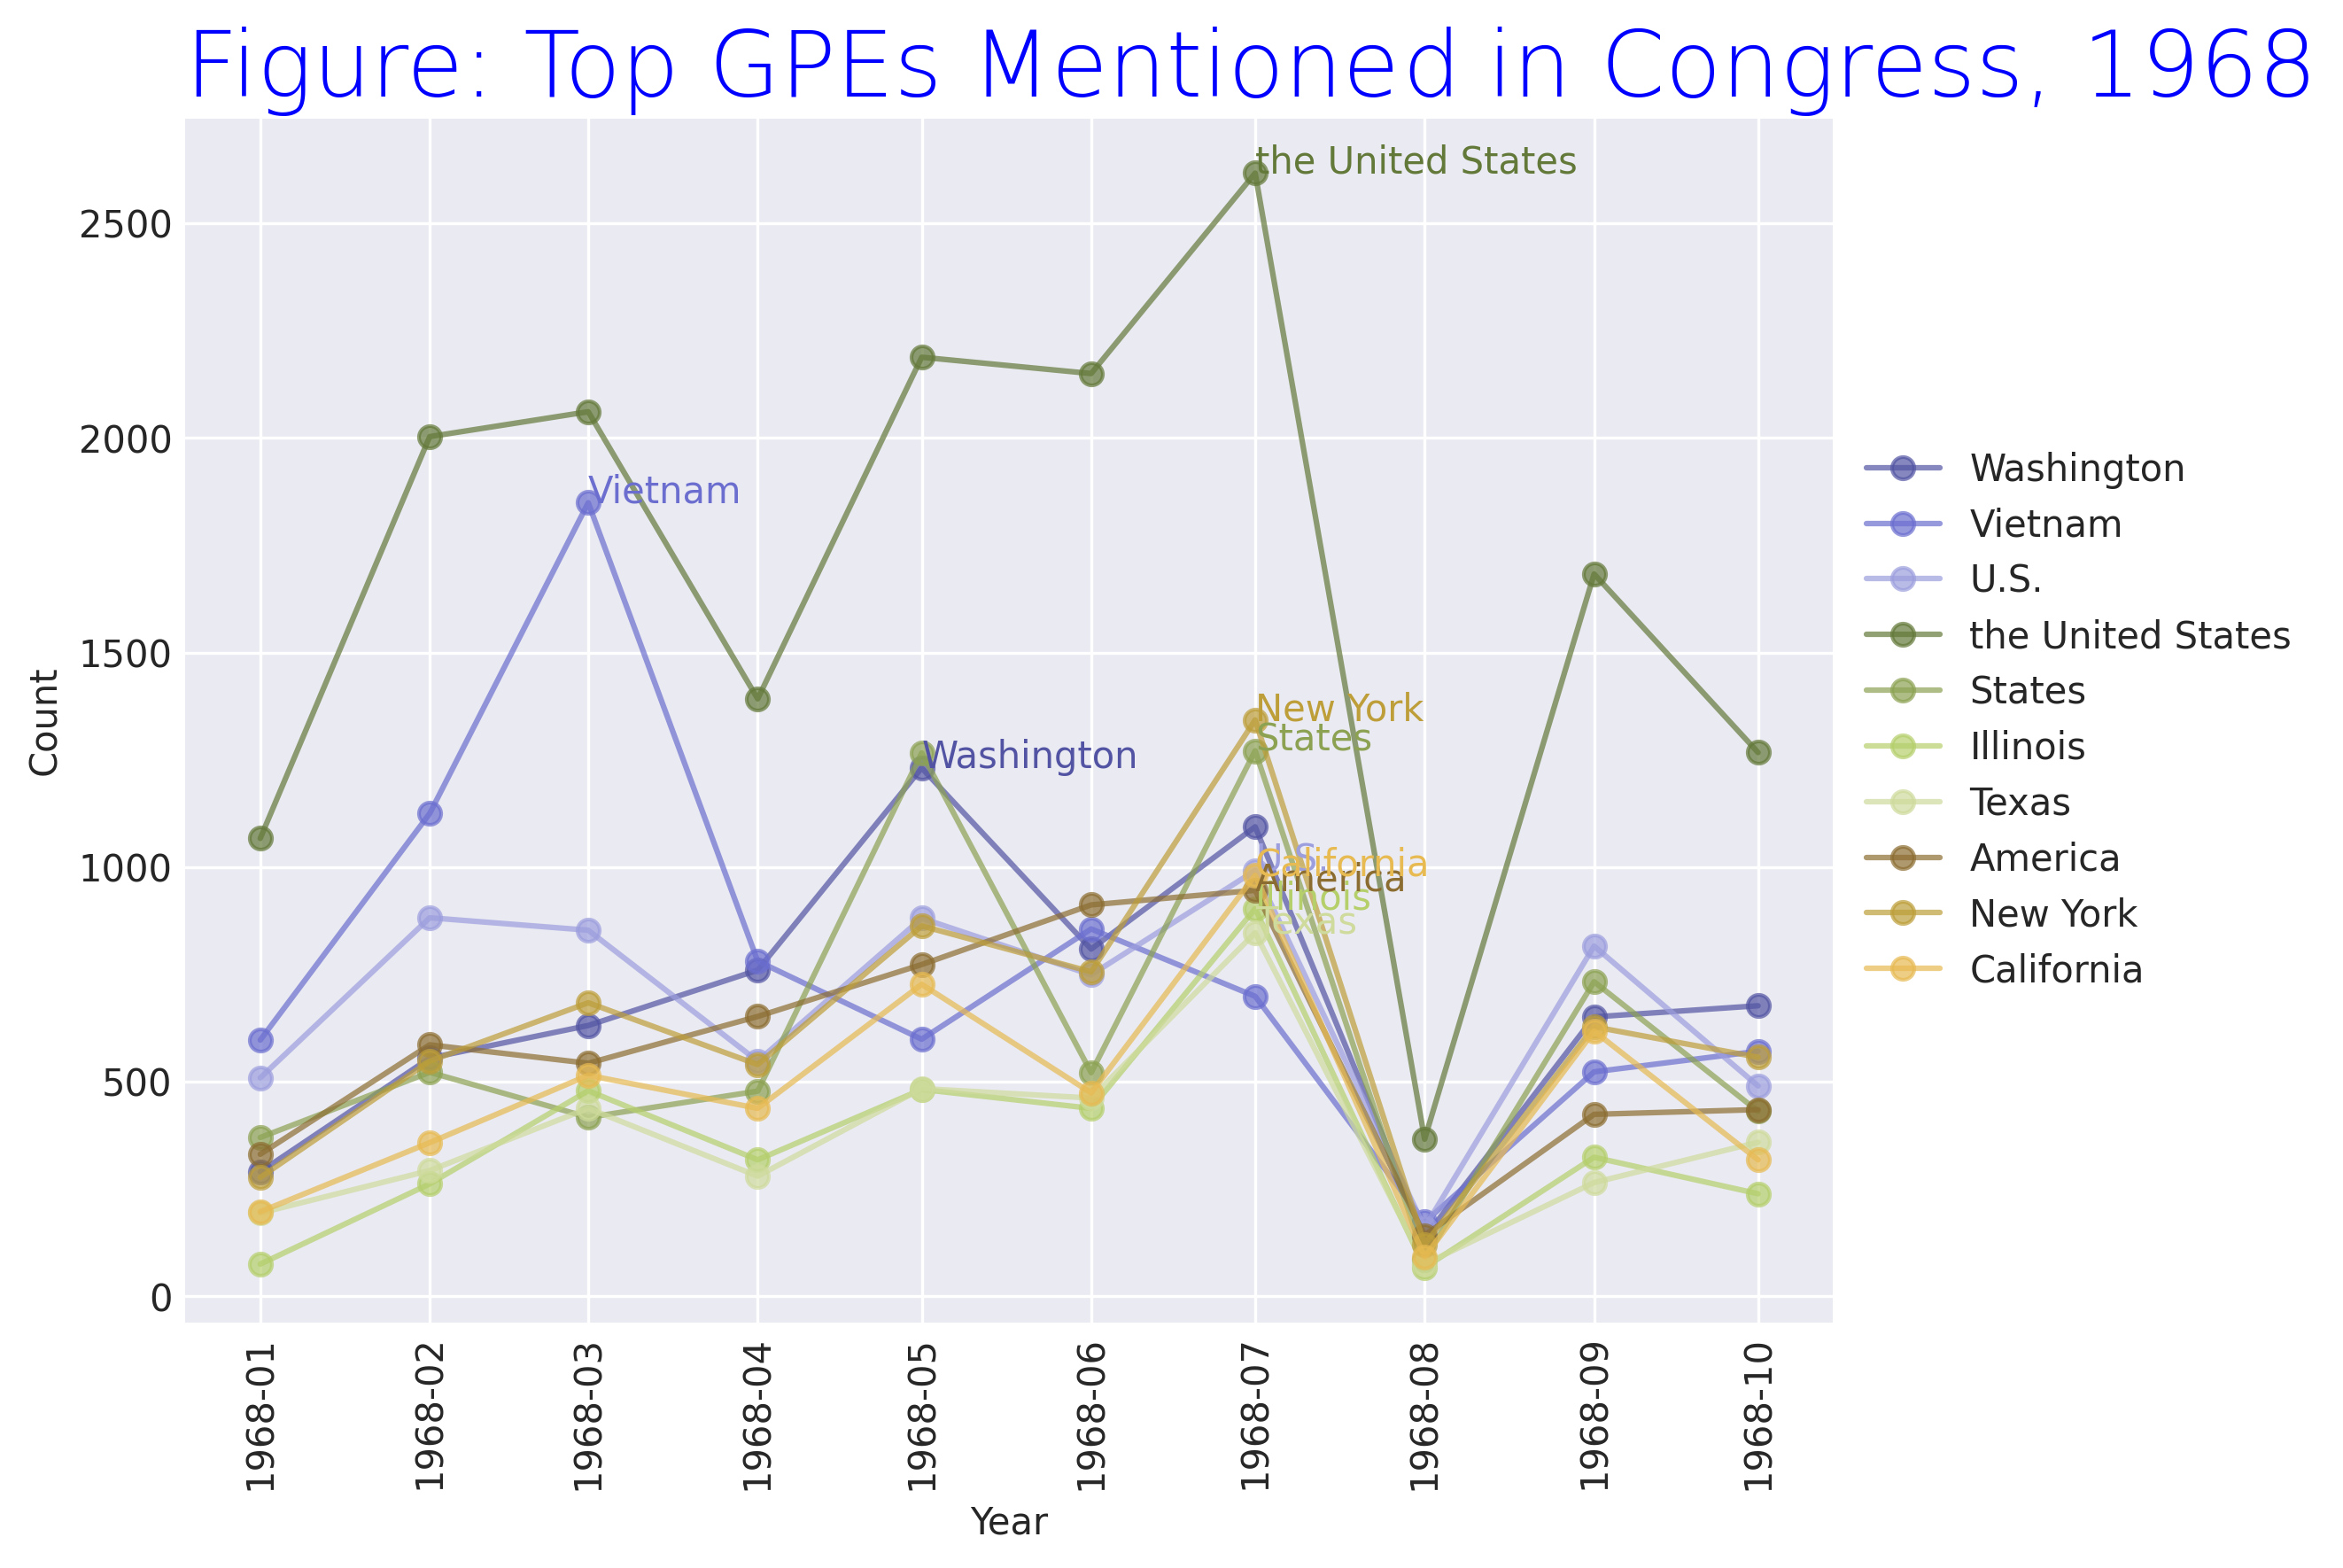

<Figure size 432x288 with 0 Axes>

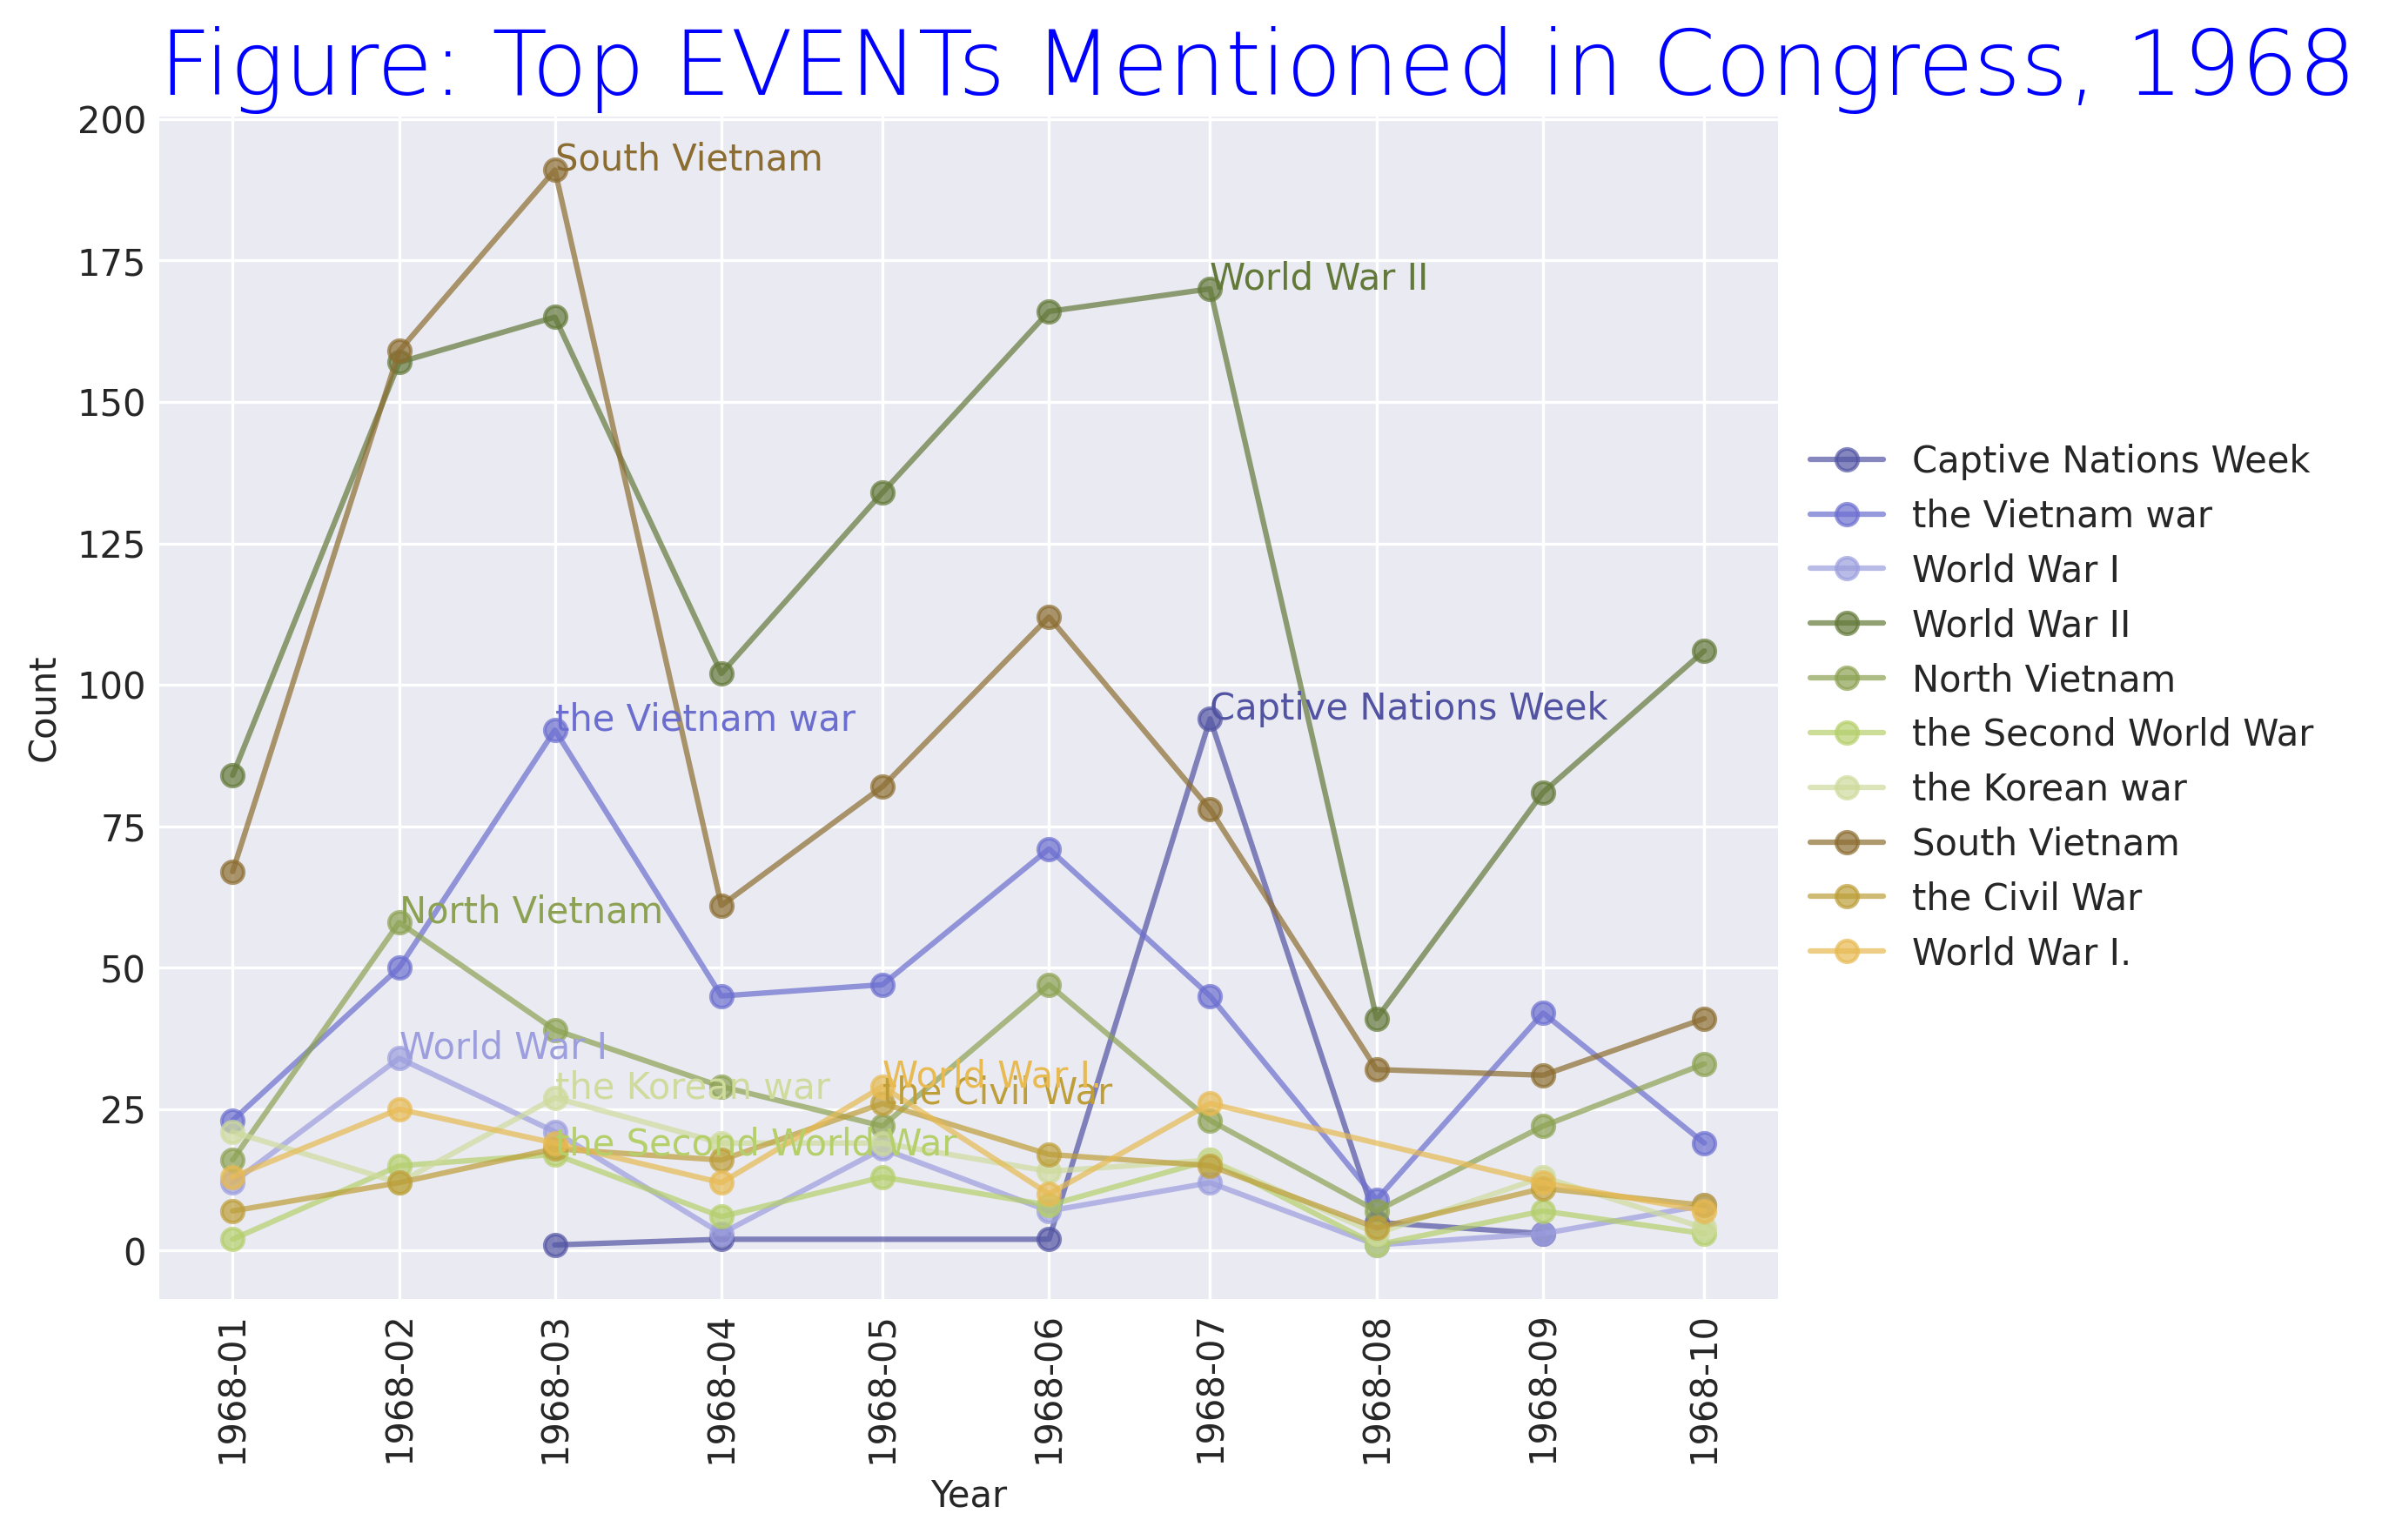

<Figure size 432x288 with 0 Axes>

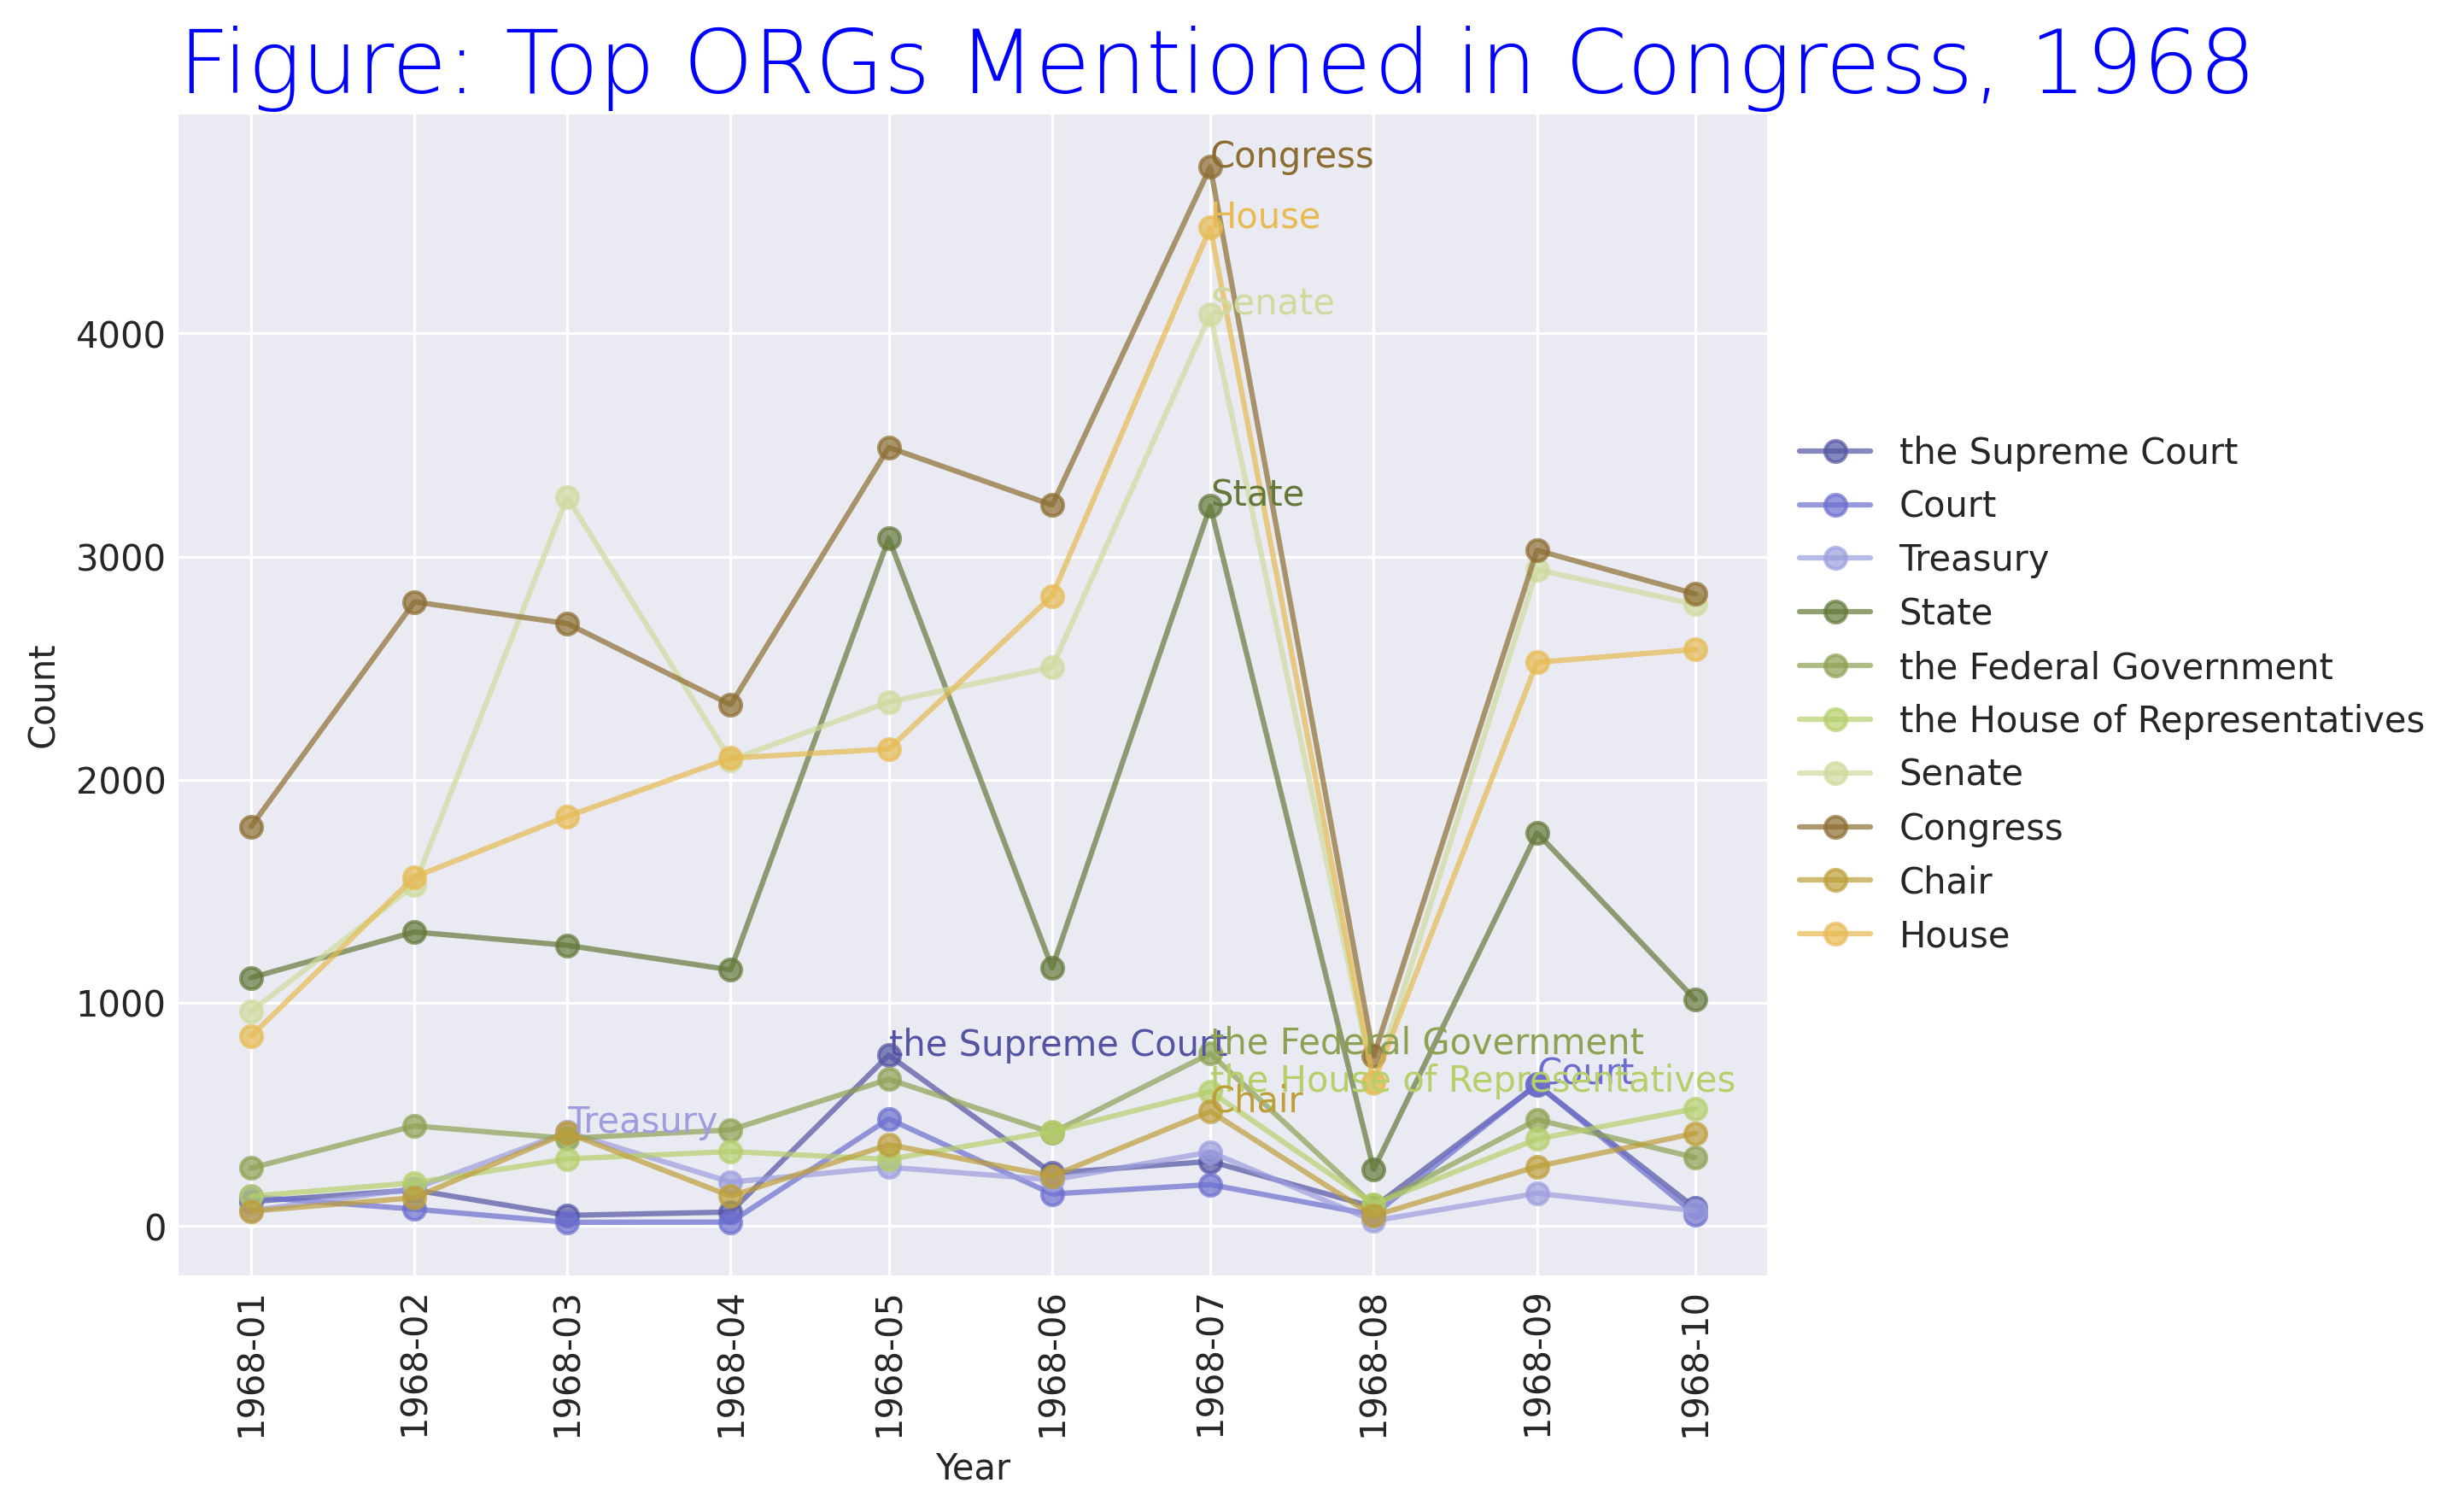

<Figure size 432x288 with 0 Axes>

In [117]:
for cat in ['LAW', 'LOC', 'PERSON', 'GPE', 'EVENT', 'ORG']:
    ner_mapper_from_csv(cat, 'congress-1968')

In [13]:
finish = time.time()
print(finish-start)

26.207531452178955


### Congress 1967-2010

In [8]:
name = 'congress-1967-2010'

In [9]:
import time
start = time.time()

In [ ]:
##### Here's the code to extract the named entities from the entire set of congress 1967-2010:
#named_entities = [nlp(doc) for doc in congress['speech']] # without progress bar 
#named_entities = logged_apply(congress['speech'], lambda x: nlp(x)) # with progress bar
named_entities = parallelize_operation(congress['speech'], apply_nlp)
#named_entities = parallelize_operation(congress['speech'], logged_ner_extractor) # over multiple cores

In [ ]:
finish = time.time()
print(finish-start)

In [ ]:
all_entities_to_csv(named_entities, congress, name)

In [ ]:
for cat in ['LAW', 'LOC', 'PERSON', 'GPE', 'EVENT', 'ORG', 'LANGUAGE']:
    ner_mapper_from_csv(cat, name)